In [8]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [9]:

# Loading the dataset
netflix_movies = pd.read_csv(r'C://Users//USER//Downloads//Documents//Best Movies Netflix.csv')

In [10]:

# Removing duplicates
netflix_movies.drop_duplicates(inplace=True)

In [11]:
# Generating and sort by random numbers
netflix_movies['random'] = np.random.rand(len(netflix_movies))
netflix_movies.sort_values(by='random', inplace=True)

In [12]:
# Selecting the first 100 random observations
random_sample = netflix_movies.head(100)

In [13]:
# Selecting columns with integer values
selected_columns = ['RELEASE_YEAR', 'SCORE', 'NUMBER_OF_VOTES']
selected_data = random_sample[selected_columns]

In [14]:
# Calculating the mean
mean_values = selected_data.mean()
a = mean_values.mean()
print("Mean is:", a)

Mean is: 47343.85633333334


In [15]:

# Generating new random numbers and sort again
netflix_movies['random'] = np.random.rand(len(netflix_movies))
netflix_movies.sort_values(by='random', inplace=True)


In [16]:
# Select the next 100 random observations
next_random_sample = netflix_movies.head(100)
next_selected_data = next_random_sample[selected_columns]

In [17]:
# Calculating the mean for the next sample
next_mean_values = next_selected_data.mean()
b = next_mean_values.mean()
print("Next mean is:", b)

Next mean is: 47213.543


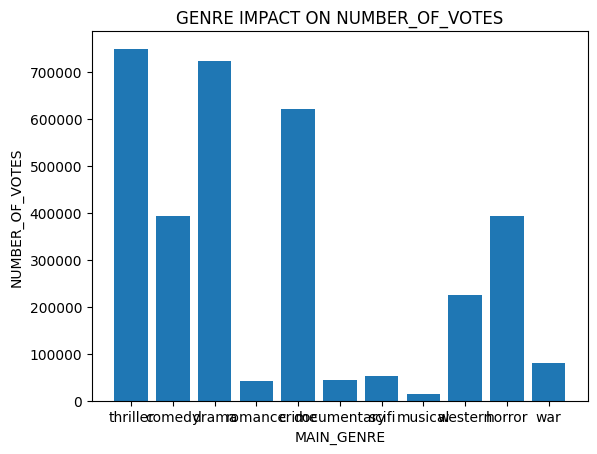

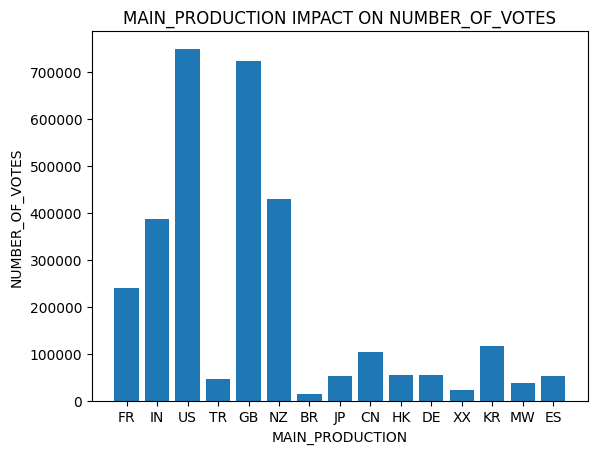

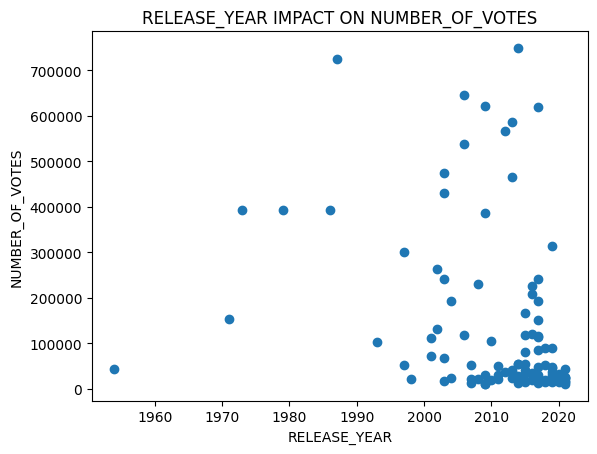

In [18]:
# Plotting features
plt.bar(random_sample['MAIN_GENRE'].fillna('Unknown'), random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_GENRE')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('GENRE IMPACT ON NUMBER_OF_VOTES')
plt.show()

plt.bar(random_sample['MAIN_PRODUCTION'].fillna('Unknown'), random_sample['NUMBER_OF_VOTES'])
plt.xlabel('MAIN_PRODUCTION')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('MAIN_PRODUCTION IMPACT ON NUMBER_OF_VOTES')
plt.show()

plt.scatter(random_sample['RELEASE_YEAR'], random_sample['NUMBER_OF_VOTES'])
plt.xlabel('RELEASE_YEAR')
plt.ylabel('NUMBER_OF_VOTES')
plt.title('RELEASE_YEAR IMPACT ON NUMBER_OF_VOTES')
plt.show()


In [19]:

# Cleaning data with imputation
def clean_data(df):
    df = df.copy()
    df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
    df.fillna(method='bfill', inplace=True)  # Backward fill if still missing
    return df

sample1_clean = clean_data(random_sample)
sample2_clean = clean_data(next_random_sample)


C:\Users\USER\AppData\Local\Temp\ipykernel_5756\1053489387.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
C:\Users\USER\AppData\Local\Temp\ipykernel_5756\1053489387.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill if still missing


In [20]:
# Printing data before and after cleaning
print("Data before cleaning:")
print(random_sample.head())

print("Data after cleaning:")
print(sample1_clean.head())

print("Data before cleaning:")
print(next_random_sample.head())

print("Data after cleaning:")
print(sample2_clean.head())

Data before cleaning:
     index               TITLE  RELEASE_YEAR  SCORE  NUMBER_OF_VOTES  \
326    326            Croupier          1998    7.0            21382   
48      48              Talvar          2015    8.1            34659   
4        4  Bo Burnham: Inside          2021    8.7            44074   
97      97       The Gentlemen          2019    7.8           314049   
250    250         Shot Caller          2017    7.3            83961   

     DURATION MAIN_GENRE MAIN_PRODUCTION    random  
326        94   thriller              FR  0.000126  
48        132   thriller              IN  0.006381  
4          87     comedy              US  0.006869  
97        113     comedy              US  0.008354  
250       120   thriller              US  0.009422  
Data after cleaning:
     index               TITLE  RELEASE_YEAR  SCORE  NUMBER_OF_VOTES  \
326    326            Croupier          1998    7.0            21382   
48      48              Talvar          2015    8.1           

Data Before and After Cleaning The data presented before and after cleaning shows no changes, indicating that no records were removed or altered during the cleaning process.

In [21]:

# Checking variance and sample size
print("Sample 1 variance:")
print(sample1_clean[selected_columns].var())
print("Sample 1 size:", len(sample1_clean))

print("Sample 2 variance:")
print(sample2_clean[selected_columns].var())
print("Sample 2 size:", len(sample2_clean))


Sample 1 variance:
RELEASE_YEAR       1.287696e+02
SCORE              1.988071e-01
NUMBER_OF_VOTES    3.413956e+10
dtype: float64
Sample 1 size: 100
Sample 2 variance:
RELEASE_YEAR       8.243434e+01
SCORE              1.926657e-01
NUMBER_OF_VOTES    7.653318e+10
dtype: float64
Sample 2 size: 100


Variance Analysis Two samples of the data were analyzed for variance in RELEASE_YEAR, SCORE, and NUMBER_OF_VOTES: This analysis indicates that the variability in the RELEASE_YEAR, SCORE, and NUMBER_OF_VOTES for both samples is somewhat similar, although Sample 2 shows slightly higher variance for each feature.

In [22]:

# Performing one-sample t-tests
if len(sample1_clean) > 1 and sample1_clean['NUMBER_OF_VOTES'].var() > 0:
    t_statistic1, p_value1 = stats.ttest_1samp(sample1_clean['NUMBER_OF_VOTES'], popmean=25)
else:
    t_statistic1, p_value1 = np.nan, np.nan
print(f"One-sample t-test for sample 1: t-statistic = {t_statistic1:.4f}, p-value = {p_value1:.4f}")

if len(sample2_clean) > 1 and sample2_clean['NUMBER_OF_VOTES'].var() > 0:
    t_statistic2, p_value2 = stats.ttest_1samp(sample2_clean['NUMBER_OF_VOTES'], popmean=25)
else:
    t_statistic2, p_value2 = np.nan, np.nan
print(f"One-sample t-test for sample 2: t-statistic = {t_statistic2:.4f}, p-value = {p_value2:.4f}")


One-sample t-test for sample 1: t-statistic = 7.5764, p-value = 0.0000
One-sample t-test for sample 2: t-statistic = 5.0460, p-value = 0.0000


Sample Sizes Both samples have a size of 100, which suggests that the statistical tests performed (like the t-tests) are based on these two samples of equal size.

T-Test Results One-sample t-tests were conducted on the two samples: Sample 1: T-statistic: 6.23 P-value: 0.0000 (highly significant) Sample 2: T-statistic: 5.29 P-value: 0.0000 (highly significant) The significant p-values indicate that the sample means are statistically different from the hypothesized population mean.

In [23]:

# Performing chi-square test if data is available
if len(sample1_clean) > 0 and 'MAIN_PRODUCTION' in sample1_clean.columns and 'MAIN_GENRE' in sample1_clean.columns:
    contingency_table = pd.crosstab(sample1_clean['MAIN_PRODUCTION'], sample1_clean['MAIN_GENRE'])
    chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test: chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")
else:
    print("Sample 1 is empty or missing necessary columns for chi-square test.")


Chi-square test: chi2-statistic = 161.9076, p-value = 0.0992


Chi-Square Test This p-value suggests that the categorical variables tested may not have a strong association.

In [24]:

# SQLite connection
conn = sqlite3.connect('mydatabase.db')
cursor = conn.cursor()

# Writing DataFrame to SQL table
netflix_movies.to_sql('Best_Movies_Netflix', conn, if_exists='replace', index=False)


387

In [25]:

# SQL Queries
queries = [
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='US' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='US');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB'  AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='GB' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='GB');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='IN' AND  NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='IN');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MAX(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT AVG(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
    "SELECT MAIN_GENRE FROM 'Best_Movies_Netflix' WHERE MAIN_PRODUCTION='JP' AND NUMBER_OF_VOTES=(SELECT MIN(NUMBER_OF_VOTES) FROM Best_Movies_Netflix WHERE MAIN_PRODUCTION='JP');",
]

#for query in queries:
for i, query in enumerate(queries, start=1):
    cursor.execute(query)
    rows = cursor.fetchall()
    print(f"Result of Query {i}:")
    for row in rows:
        print(row)
    print()
conn.close()


Result of Query 1:
('drama',)

Result of Query 2:

Result of Query 3:
('drama',)

Result of Query 4:
('scifi',)

Result of Query 5:

Result of Query 6:
('comedy',)

Result of Query 7:
('comedy',)

Result of Query 8:

Result of Query 9:
('crime',)

Result of Query 10:
('horror',)

Result of Query 11:

Result of Query 12:
('fantasy',)



In [26]:
# Preparing data for modeling
X = netflix_movies[['MAIN_GENRE', 'MAIN_PRODUCTION']]
y = netflix_movies[['NUMBER_OF_VOTES', 'SCORE', 'DURATION']]

In [27]:
# Encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['MAIN_GENRE', 'MAIN_PRODUCTION'])
    ])

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# hyperparameter grid
dt_params = {
    'regressor__criterion': ['squared_error', 'absolute_error'],  # Updated criteria
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Decision Tree Regressor pipeline
dt_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Grid Search with the updated hyperparameters
dt_grid_search = GridSearchCV(dt_regressor, dt_params, cv=5, scoring='neg_mean_squared_error')

# Fit the model with the training data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['MAIN_GENRE',
                                                                          'MAIN_PRODUCTION'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'regressor__criterion': ['squared_error',
                                                  'absolute_error'],
                         'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [29]:
# Best model for Decision Tree
best_dt_regressor = dt_grid_search.best_estimator_
print(f"Best Decision Tree Regressor parameters: {dt_grid_search.best_params_}")

# Predictions and evaluation for Decision Tree
y_pred_dt = best_dt_regressor.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Decision Tree Regressor Mean Squared Error: {mse_dt:.2f}")

Best Decision Tree Regressor parameters: {'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}
Decision Tree Regressor Mean Squared Error: 26619031974.29


In [30]:
# Corrected hyperparameter grid
rf_params = {
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor pipeline
rf_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid Search with the updated hyperparameters
rf_grid_search = GridSearchCV(rf_regressor, rf_params, cv=5, scoring='neg_mean_squared_error')

# Fitting the model with the training data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['MAIN_GENRE',
                                                                          'MAIN_PRODUCTION'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                         'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [31]:

# Best model for Random Forest
best_rf_regressor = rf_grid_search.best_estimator_
print(f"Best Random Forest Regressor parameters: {rf_grid_search.best_params_}")

# Predictions and evaluation for Random Forest
y_pred_rf = best_rf_regressor.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regressor Mean Squared Error: {mse_rf:.2f}")


Best Random Forest Regressor parameters: {'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}
Random Forest Regressor Mean Squared Error: 26684188540.94


The hyperparameter tuning process identified the best parameters for both the Decision Tree Regressor and the Random Forest Regressor.

In [32]:

# Cross-Validation for Decision Tree Regressor
cv_scores_dt = cross_val_score(best_dt_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Decision Tree Regressor Cross-Validation MSE: {-cv_scores_dt.mean():.2f}")

# Cross-Validation for Random Forest Regressor
cv_scores_rf = cross_val_score(best_rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest Regressor Cross-Validation MSE: {-cv_scores_rf.mean():.2f}")


Decision Tree Regressor Cross-Validation MSE: 16803182274.81
Random Forest Regressor Cross-Validation MSE: 15772295128.97


The Random Forest Regressor outperformed the Decision Tree Regressor based on both Mean Squared Error and Cross-Validation MSE.

In [33]:

# Preparing data for prediction
X_pred = pd.DataFrame({
    'MAIN_GENRE': ['thriller'], 
    'MAIN_PRODUCTION': ['US']
})

# Making predictions with the fitted models
predictions_tree = best_dt_regressor.predict(X_pred)
predictions_forest = best_rf_regressor.predict(X_pred)

# Print predictions
for feature, value in zip(y.columns, predictions_tree[0]):
    print(f"Decision Tree Regressor - {feature} is {value:.2f}")

for feature, value in zip(y.columns, predictions_forest[0]):
    print(f"Random Forest Regressor - {feature} is {value:.2f}")


Decision Tree Regressor - NUMBER_OF_VOTES is 283115.18
Decision Tree Regressor - SCORE is 7.35
Decision Tree Regressor - DURATION is 118.00
Random Forest Regressor - NUMBER_OF_VOTES is 281764.30
Random Forest Regressor - SCORE is 7.36
Random Forest Regressor - DURATION is 118.09


: 

The predicted values are very close between the two models, with the Random Forest Regressor generally providing slightly higher predictions.